In [3]:
import os, glob
import numpy as np
import pydicom
from math import floor, ceil
import SimpleITK as sitk
import glob
import matplotlib.pyplot as plt


In [4]:
def read_dicom_files(dicom_dir):
    try:
        # dicom_files = glob.glob(os.path.join(dicom_dir, "*.*"))
        dicom_files = [os.path.join(dicom_dir, dicom_file) for dicom_file in os.listdir(dicom_dir)]
        sorted_dicom_files = sorted(dicom_files)
        stacked_dicom = [pydicom.dcmread(dicom_file) for dicom_file in sorted_dicom_files]
        return stacked_dicom
    except IndexError as e:
        print(f"{e}, at path {dicom_dir}")
        return None

In [5]:
def create_3d_vol(path_dicom_A):
    dicom_stacks_A = read_dicom_files(path_dicom_A)

    image_shape_A = list(dicom_stacks_A[0].pixel_array.shape)
    image_shape_A.append(len(dicom_stacks_A))

    image_3d_A = np.zeros(image_shape_A)

    for j in range(len(dicom_stacks_A)):
        image_3d_A[:, :, j] = dicom_stacks_A[j].pixel_array

    return image_3d_A

In [6]:
dicom_path = "/media/monib/ext1/work2022/Base_Dataset/3d_con_d_p_mask_dicom/D/HCC_1178_d"
img_3d = create_3d_vol(dicom_path)
img_3d.shape

FileNotFoundError: [Errno 2] No such file or directory: '/media/monib/ext1/work2022/Base_Dataset/3d_con_d_p_mask_dicom/D/HCC_1178_d'

In [18]:
def patch_3d(image, patch_size):
    """
    image: a 3D CT scan image
    patch_size: a tuple of int indicating the patch size. ex (128,128,128
    """
    stride = int(patch_size / 2)

    image_patches = []
    locations = []

    for i in range(0, image.shape[0], stride):
        for j in range(0, image.shape[1], stride):
            for k in range(0, image.shape[2], stride):
                patch_img = image[i:i + patch_size, j:j + patch_size, k:k + patch_size]
                image_patches.append(patch_img)
                locations.append((i, j, k))

    return image_patches, locations

3


In [18]:
def loadpatch(image, patch_size):
    x, y, z = image.shape

    x_coor = np.random.randint(0, x-patch_size)
    y_coor = np.random.randint(0, y-patch_size)
    z_coor = np.random.randint(0, z-patch_size)

    return image[x_coor:x_coor + patch_size, y_coor:y_coor + patch_size, z_coor:z_coor + patch_size]

In [21]:
img = loadpatch(img_3d, 60)
img.shape

(60, 60, 60)

In [34]:
import torch
import pdb
folders_path = "../exp_input_data/train/example_A"
folders = glob.glob(folders_path + "/*")
print(folders)

reader = sitk.ImageSeriesReader()

for folder in folders:

    dicom_names = reader.GetGDCMSeriesFileNames(folder)
    reader.SetFileNames(dicom_names)

    image = reader.Execute()
    img_ndarray = sitk.GetArrayFromImage(image)

    torch_img = torch.from_numpy(img_ndarray)
    print("image shape", torch_img.shape)

    a, b, c  = torch_img.shape
    patch_size = 64

    image_patches = []
    locations = []
    a_coor, b_coor, c_coor = 0, 0, 0

    # for i in range(5):
    #
    #
    #     print("a_coor: ", a_coor)
    #     print("b_coor: ", b_coor)
    #     print("c_coor: ", c_coor)
    #
    #     patch_image = torch_img[a_coor:a_coor + patch_size, b_coor:b_coor + patch_size, c_coor:c_coor + patch_size]
    #     patch_image[...] = 0
    #     image_patches.append(patch_image)
    #     locations.append((a_coor, b_coor, c_coor))

        # a_coor = a_coor + 2
        # b_coor = b_coor + 2
        # c_coor = c_coor + 2

        # if patch_image.shape != (patch_size, patch_size, patch_size):
            # print(patch_image.shape)
        # print("patch image shape:", patch_image.shape)
        # plt.imshow(patch_image[0], cmap='gray')
        # plt.show()
    break
    # pdb.set_trace()

['../exp_input_data/train/example_A/HCC_1246_d', '../exp_input_data/train/example_A/HCC_1247_d', '../exp_input_data/train/example_A/HCC_1248_d', '../exp_input_data/train/example_A/HCC_1249_d', '../exp_input_data/train/example_A/HCC_1250_d']
image shape torch.Size([66, 512, 512])


In [35]:
rec_img = np.zeros(img_ndarray.shape)

patch_size = 64
patches, locs= patch_3d(img_ndarray, patch_size)
print(len(patches))
patches[0].shape

768


(64, 64, 64)

In [42]:
for idx in range(len(locs)):
    a_coor,b_coor,c_coor = locs[idx]
    if idx%2 == 0:
        rec_img[a_coor:a_coor + patch_size, b_coor:b_coor + patch_size, c_coor:c_coor + patch_size] = patches[idx]
    else:
        rec_img[a_coor:a_coor + patch_size, b_coor:b_coor + patch_size, c_coor:c_coor + patch_size] = 0

(66, 512, 512)

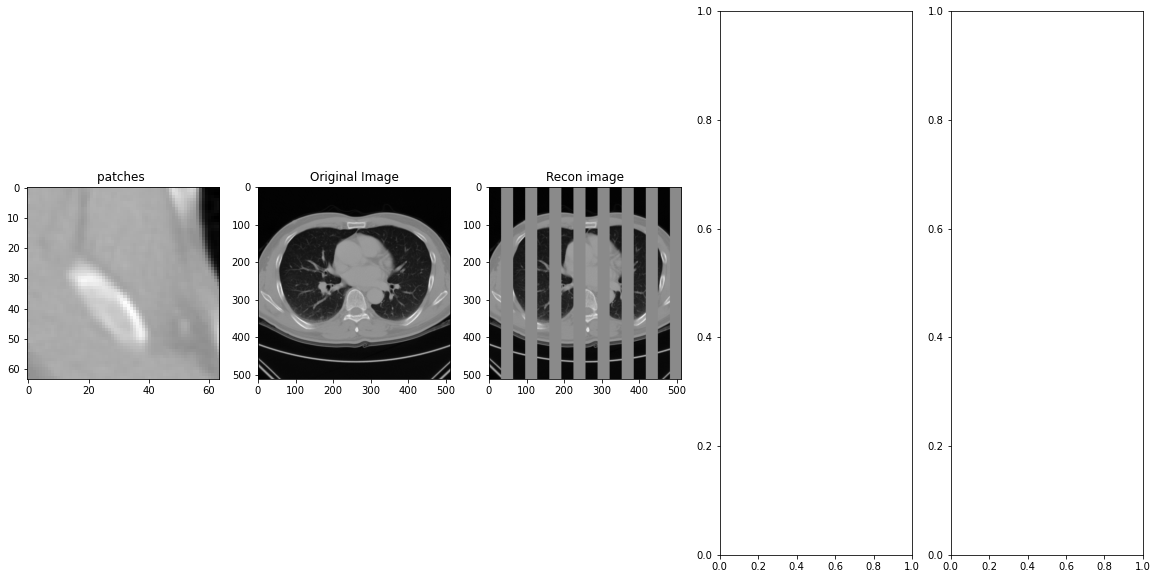

In [43]:
fig, (ax1, ax2, ax3, ax4, ax5) =plt.subplots(1,5, figsize = (20, 10))
ax1.set_title("patches ")
ax1.imshow(patches[768//2][30, :, :], cmap='gray')
ax2.set_title("Original Image")
ax2.imshow(img_ndarray[65, :, :], cmap='gray')
ax3.set_title("Recon image")
ax3.imshow(rec_img[65, :, :], cmap='gray')

rec_img.shape


# Plot a few patches images

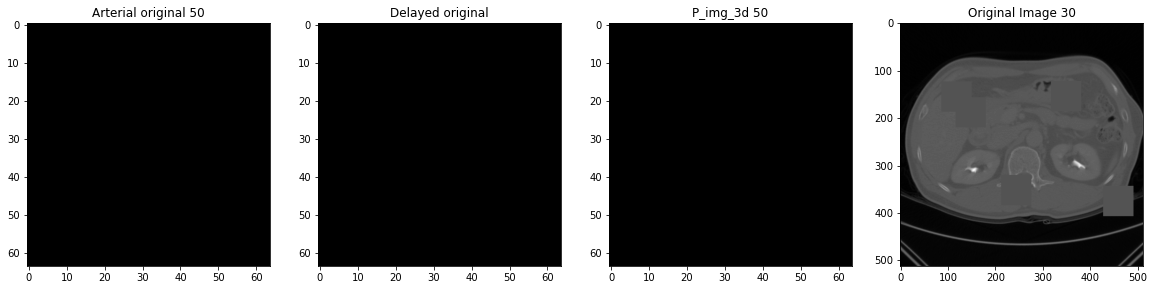

In [32]:
fig, (ax1, ax2, ax3, ax4) =plt.subplots(1,4, figsize = (20, 10))
ax1.set_title("Arterial original 50")
ax1.imshow(image_patches[0][:, :, 30], cmap='gray')
ax2.set_title("Delayed original")
ax2.imshow(image_patches[1][:, :, 30], cmap='gray')
ax3.set_title("P_img_3d 50")
ax3.imshow(image_patches[2][:, :, 30], cmap='gray')

ax4.set_title("Original Image 30")
ax4.imshow(img_ndarray[30, :, :], cmap='gray')

In [33]:
for i in range(len(locations)):
    a_coor,b_coor,c_coor = locations[i]
    print(a_coor)
    img_ndarray[a_coor:a_coor + patch_size, b_coor:b_coor + patch_size, c_coor:c_coor + patch_size] = image_patches[i]


0
1
1
0
1


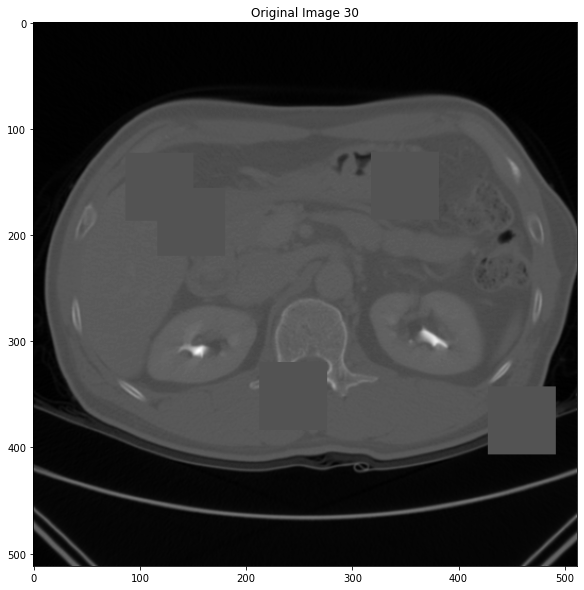

In [34]:
fig, (ax1) =plt.subplots(1,1, figsize = (20, 10))
ax1.set_title("Original Image 30")
ax1.imshow(img_ndarray[30, :, :], cmap='gray')